# 행정구역별 의료기관 현황 분석 
## 데이터 준비 및 탐색
### [행정구역 이름으로 주소수정]

In [2]:
import pandas as pd
pd.set_option('mode.chained_assignment', None)
import numpy as np

In [ ]:
data = pd.read_csv('./data/공공보건의료기관현황.csv', 
	index_col = 0,encoding = ' CP949', engine = 'python') 
data.head()

,병원 명,설립형태,근거 법령,관계 행정기관,관계 공공단체,심평원 요양기관번호,종별구분,병상수,소재지 우편번호,주소,홈페이지,대표전화,FAX,비고
연번,,,,,,,,,,,,,,
1,강원도 재활병원,시도립,강원도재활병원설치및운영에관한조례,강원도,해당없음,32200641,병원,165,24227,강원도 춘천시 충열로 142번길 24-16,www.grh.or.kr,033-248-7700,033-248-7723,NaN
2,강원도 삼척의료원,특수법인,지방의료원의 설립 및 운영에 관한 법률,보건복지부(강원도),지방의료원,32100060,종합병원,152,25920,강원도 삼척시 오십천로 418,http://ksmc.or.kr,033-572-1141,033-573-8424,NaN
3,강원도 영월의료원,특수법인,지방의료원의 설립 및 운영에 관한 법률,보건복지부(강원도),지방의료원,32100078,종합병원,214,26234,강원도 영월군 영월읍 중앙1로 59,http://www.youngwol.org,033-370-9117,033-370-9137,NaN
4,강원도 원주의료원,특수법인,지방의료원의 설립 및 운영에 관한 법률,보건복지부(강원도),지방의료원,32100086,종합병원,237,26448,강원도 원주시 서원대로 387(개운동),www.kwmc.or.kr,033-760-4500,033-761-5121,NaN
5,강원도 강릉의료원,특수법인,지방의료원의 설립 및 운영에 관한 법률,보건복지부(강원도),지방의료원,32100159,종합병원,137,25535,강원도 강릉시 경강로 2007(남문동 164-1),http://www.gnmc.or.kr,033-646-6910,033-610-1415,NaN


### [주소에서 시도, 군구 정보 분리]

In [4]:
addr = pd.DataFrame(data['주소'].apply(lambda v: v.split()[:2]).tolist(), columns = ('시도', '군구'))
# 시군과 군구 정보에 해당하는 0~1번 컬럼 [:2]을 추출해서 컬럼 이름을 ‘시도’, ‘군구’로 나타냄
# Data의 주소 컬럼만 추출 >주소를 빈칸을 기준으로 자름(람다식) >두번째 값까지만 획득 >컬럼 시도, 군구로 지정
# 데이터프레임 객체인 addr을 생성
addr.head()

,시도,군구
0,강원도,춘천시
1,강원도,삼척시
2,강원도,영월군
3,강원도,원주시
4,강원도,강릉시


### [시도 이름에서 잘못된 내용 있는지 확인/잘못된 위치 찾아 수정]

In [5]:
addr['시도'].unique()
# unique로 중복제거 : addr 객체의 [‘시도’] 컬럼 값에서 고유값을 확인

array(['강원도', '경기도', '경기', '경남', '창원시', '경상남도', '경상북도', '경산시', '경북',
       '인천광역시', '대구광역시', '전라남도', '대전광역시', '광주광역시', '제주특별자치도', '부산광역시',
       '전라북도', '충북', '서울특별시', '서울시', '부산특별시', '대전시', '충남', '전남', '충청남도',
       '울산광역시', '전북', '천안시', '충청북도'], dtype=object)

**잘못된 위치 찾아서 수정**
- 시/도에는 ‘도’와 ‘광역시’만 맞는값인데, 창원시, 경산시 이런게 시/도에 들어가 있음. 
- 그냥 엑셀에서 수정하는게 편하긴 하지만,, 일단은 파이썬으로 수정해보기

- [‘시도’] 컬럼 값이 ‘창원시’로 되어 있는 행 번호를 찾아보니 27번과 31번
- 27번과 31번의 값을 [‘경상남도’, ‘창원시’]로 수정
- 경산시, 천안시도 마찬가지로 확인하고, 수정

In [ ]:
addr[addr['시도'] == '창원시']

,시도,군구
27,창원시,의창구
31,창원시,마산합포구3.15대로


In [7]:
addr.iloc[27] = ['경상남도', '창원시']
addr.iloc[31] = ['경상남도', '창원시']

In [8]:
addr[addr['시도'] == '경산시']

,시도,군구
47,경산시,경안로


In [9]:
addr.iloc[27] = ['경상남도', '경산시']

In [10]:
addr[addr['시도'] == '천안시']

,시도,군구
209,천안시,동남구
210,천안시,동남구


In [11]:
addr.iloc[209] = ['충청남도', '천안시'] 
addr.iloc[210] = ['충청남도', '천안시']

### [‘경기’, ‘경남’과 같이 축약된 이름을 정확한 표준 이름으로 수정]

In [12]:
addr_aliases = {'경기':'경기도', '경남':'경상남도', '경북':'경상북도','충북':'충청북도', '서울시':'서울특별시',
	'부산특별시':'부산광역시', '대전시':'대전광역시', '충남':'충청남도','전남':'전라남도', '전북':'전라북도'}
# 변경할 이름에 대한 ‘축약이름:표준이름’의 addr_aliases 딕셔너리를 정의

addr['시도'] = addr['시도'].apply(lambda v: addr_aliases.get(v, v))
# addr_aliases 딕셔너리를 적용하여 [‘시도’] 컬럼의 값을 변경
# 람다식 : Dictionary.get(찾는값, 없는경우 리턴값)
addr['시도'].unique()
# addr 객체의 [‘시도’] 컬럼 고유값을 출력하여 빠짐없이 변경되었는지 확인

array(['강원도', '경기도', '경상남도', '경상북도', '경산시', '인천광역시', '대구광역시', '전라남도',
       '대전광역시', '광주광역시', '제주특별자치도', '부산광역시', '전라북도', '충청북도', '서울특별시',
       '충청남도', '울산광역시'], dtype=object)

In [ ]:
addr['군구'].unique()
# 마찬가지로 '군구' 컬럼에서도 정리할 사항이 있는지 확인
# addr 객체의 [‘군구’] 컬럼의 고유값을 확인 

array(['춘천시', '삼척시', '영월군', '원주시', '강릉시', '속초시', '정선군', '수원시', '이천시',
       '안성시', '의정부시', '포천시', '파주시', '용인시', '평택시', '시흥시', '여주시', '남양주시',
       '동두천시', '안산시', '부천시', '통영시', '사천시', '경산시', '김해시', '양산시', '거창군',
       '창원시', '남해군', '의령군', '포항시', '김천시', '안동시', '울진군', '경주시', '구미시',
       '영주시', '상주시', '문경시', '경안로', '의성군', '청도군', '고령군', '칠곡군', '봉화군',
       '울릉군', '부평구', '북구', '순천시', '대덕구', '태백시', '동해시', '화성시', '광산구', '남구',
       '중구', '아란13길', '서구', '전주시', '진주시', '청주시', '종로구', '성남시', '동구',
       '화순군', '강동구', '사상구', '달서구', '해운대구', '유성구', '가평군', '양주시', '고양시',
       '홍천군', '양구군', '청원군', '계룡시', '논산시', '함평군', '양평군', '수성구', '달성군',
       '연수구', '노원구', '기장군', '공주시', '강북구', '광진구', '나주시', '창녕군', '목포시',
       '고흥군', '연제구', '동매로', '서초구', '은평구', '중랑구', '강남구', '동작구', '동대문구',
       '양천구', '성동구', '송파구', '울주군', '계양구', '옹진군', '보성군', '광양시', '영광군',
       '무안군', '진도군', '강진군', '곡성군', '여수시', '신안군', '장성군', '완주군', '부안군',
       '정읍시', '남원시', '군산시', '고창군', '진안군', '제주시', '서귀포시', '천안시', '보령시',
       '서산

In [ ]:
addr[addr['군구'] == '아란13길']
# 아란13길’을 인터넷에서 검색해보면 제주시에 있는 도로명이므로 ‘제주시’로 수정

,시도,군구
75,제주특별자치도,아란13길


In [ ]:
addr.iloc[75] = ['제주특별자치도', '제주시']
# [‘군구’] 컬럼 값이 ‘아란13길’로 되어 있는 행 번호를 찾아보니 75번
# 75번 행의 값을 [‘제주특별자치도’, ‘제주시’]로 수정

## 행정구역별 공공보건의료기관 수 집계

In [ ]:
addr['시도군구'] = addr.apply(lambda r: r['시도'] + ' ' + r['군구'], axis = 1)
# [‘시도’]와 [‘군구’] 컬럼 값을 연결하여 만든 값으로 addr 객체에 새로운 [‘시도군구’] 컬럼을 추가
addr['count'] = 0  
# count 컬럼 추가
addr.head()

,시도,군구,시도군구,count
0,강원도,춘천시,강원도 춘천시,0
1,강원도,삼척시,강원도 삼척시,0
2,강원도,영월군,강원도 영월군,0
3,강원도,원주시,강원도 원주시,0
4,강원도,강릉시,강원도 강릉시,0


In [ ]:
addr_group=pd.DataFrame(addr.groupby(['시도','군구','시도군구'],as_index=False).count())
# [‘시도’], [‘군구’], [‘시도군구’] 컬럼을 기준으로 그룹을 만듦
# 그룹별 원소의 개수를 구하여 [‘count’] 컬럼에 저장
addr_group.head()
# 강원도 춘천시 -> 가 2개 나온다면 춘천시에 보건소 2개 있다는 뜻

,시도,군구,시도군구,count
0,강원도,강릉시,강원도 강릉시,4
1,강원도,동해시,강원도 동해시,1
2,강원도,삼척시,강원도 삼척시,1
3,강원도,속초시,강원도 속초시,1
4,강원도,양구군,강원도 양구군,1


In [18]:
# 데이터 병합에 사용할 인덱스를 설정
addr_group = addr_group.set_index("시도군구")
# [‘시도군구’] 컬럼을 데이터프레임 병합에 사용할 인덱스로 설정

addr_group.head()

,시도,군구,count
시도군구,,,
강원도 강릉시,강원도,강릉시,4
강원도 동해시,강원도,동해시,1
강원도 삼척시,강원도,삼척시,1
강원도 속초시,강원도,속초시,1
강원도 양구군,강원도,양구군,1


## 행정구역별 인구수 데이터 정리

### [행정구역별 인구수 데이터 준비]

In [19]:
population = pd.read_excel('./data/행정구역_시군구_별__성별_인구수_2.xlsx')
population = population.rename(columns = {'행정구역(시군구)별1': '시도', '행정구역(시군구)별2': '군구'})
# rename() 함수를 사용하여 컬럼 이름을 변경
# 원래 엑셀파일에서 첫번째열과 두번째열의 열이름이 같았음. 1 2 를 추가해서 열이름 바꿈. 
# 귀찮으니까 엑셀가서 바꿔도 됨
population.head() 

,시도,군구,총인구수 (명),남자인구수 (명),여자인구수 (명)
0,전국,소계,51414281,25621573,25792708
1,서울특별시,소계,9426404,4566299,4860105
2,서울특별시,종로구,141060,68170,72890
3,서울특별시,중구,120963,58699,62264
4,서울특별시,용산구,217756,104640,113116


### [addr_group과 병합하기 위해 ['시도군구']를 인덱스로 설정]

In [20]:
for element in range(0,len(population)):
    population.loc[element,"군구"] = population.loc[element, "군구"].strip()
# strip( ) : [‘군구’] 컬럼의 문자열 앞뒤에 포함된 띄어쓰기 공백을 모두 제거
population['시도군구'] = population.apply(lambda r: r['시도'] + ' ' + r['군구'], axis = 1)
# [‘시도’]와 [‘군구’] 컬럼 값을 연결하여 새로운 [‘시도군구’] 컬럼에 추가
population.head()   

,시도,군구,총인구수 (명),남자인구수 (명),여자인구수 (명),시도군구
0,전국,소계,51414281,25621573,25792708,전국 소계
1,서울특별시,소계,9426404,4566299,4860105,서울특별시 소계
2,서울특별시,종로구,141060,68170,72890,서울특별시 종로구
3,서울특별시,중구,120963,58699,62264,서울특별시 중구
4,서울특별시,용산구,217756,104640,113116,서울특별시 용산구


In [24]:
population = population[population.군구 != '소계']
# 군구 컬럼 값이 소계인 행은 필요 없으므로 제외

In [ ]:
population = population.set_index("시도군구")
population.head()
# '시도군구' 컬럼을 데이터프레임 병합에 사용할 인덱스로 설정

,시도,군구,총인구수 (명),남자인구수 (명),여자인구수 (명)
시도군구,,,,,
서울특별시 종로구,서울특별시,종로구,141060,68170,72890
서울특별시 중구,서울특별시,중구,120963,58699,62264
서울특별시 용산구,서울특별시,용산구,217756,104640,113116
서울특별시 성동구,서울특별시,성동구,280240,136233,144007
서울특별시 광진구,서울특별시,광진구,336801,162209,174592


## 테이블에 필요한 컬럼 추출 후 테이블 병합

### [addr_group과 population을 인덱스 기준으로 병합 ]

In [26]:
addr_population_merge = pd.merge(addr_group, population, how = 'inner',left_index = True, right_index = True)
# addr_group과 population을 인덱스 기준으로 inner join으로 합침
addr_population_merge.head()

,시도_x,군구_x,count,시도_y,군구_y,총인구수 (명),남자인구수 (명),여자인구수 (명)
시도군구,,,,,,,,
강원도 강릉시,강원도,강릉시,4,강원도,강릉시,210678,104419,106259
강원도 동해시,강원도,동해시,1,강원도,동해시,89186,45323,43863
강원도 삼척시,강원도,삼척시,1,강원도,삼척시,63487,32220,31267
강원도 속초시,강원도,속초시,1,강원도,속초시,82541,40885,41656
강원도 양구군,강원도,양구군,1,강원도,양구군,21351,11213,10138


In [27]:
local_MC_Population = addr_population_merge[['시도_x', '군구_x','count', '총인구수 (명)']]
# 필요한 컬럼 4개만 추출해서 local_MC_population 객체를 생성
local_MC_Population.head()

,시도_x,군구_x,count,총인구수 (명)
시도군구,,,,
강원도 강릉시,강원도,강릉시,4,210678
강원도 동해시,강원도,동해시,1,89186
강원도 삼척시,강원도,삼척시,1,63487
강원도 속초시,강원도,속초시,1,82541
강원도 양구군,강원도,양구군,1,21351


### [컬럼이름 변경]

In [28]:
local_MC_Population = local_MC_Population.rename(columns = {'시도_x':'시도', '군구_x': '군구',
	'총인구수 (명)': '인구수'})
MC_count = local_MC_Population['count'] 
# MC_count : 공공보건의료기관 개수 
local_MC_Population['MC_ratio'] = MC_count.div(local_MC_Population['인구수'], axis = 0)*100000
# local_MC_Population : 100000명당 의료기관 개수
# 인구수 대비 공공보건의료기관 비율을 구하여 local_MC_Population의 [‘MC_ ratio’] 컬럼에 추가
local_MC_Population.head()


,시도,군구,count,인구수,MC_ratio
시도군구,,,,,
강원도 강릉시,강원도,강릉시,4,210678,1.898632
강원도 동해시,강원도,동해시,1,89186,1.121252
강원도 삼척시,강원도,삼척시,1,63487,1.575126
강원도 속초시,강원도,속초시,1,82541,1.211519
강원도 양구군,강원도,양구군,1,21351,4.683621


## 바 차트 그리기
### [행정구역별 공공보건의료기관 수에 대한 바 차트 그리기]

In [29]:
from matplotlib import pyplot as plt
from matplotlib import rcParams, style
style.use('ggplot') #격자설정(생략가능)


In [ ]:
from matplotlib import font_manager, rc 
font_name = font_manager.FontProperties(fname = "c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family = font_name)
# *한글 데이터기에 꼭 폰트설정을 잘 해주어야 깨지지 않고 잘 나옴.

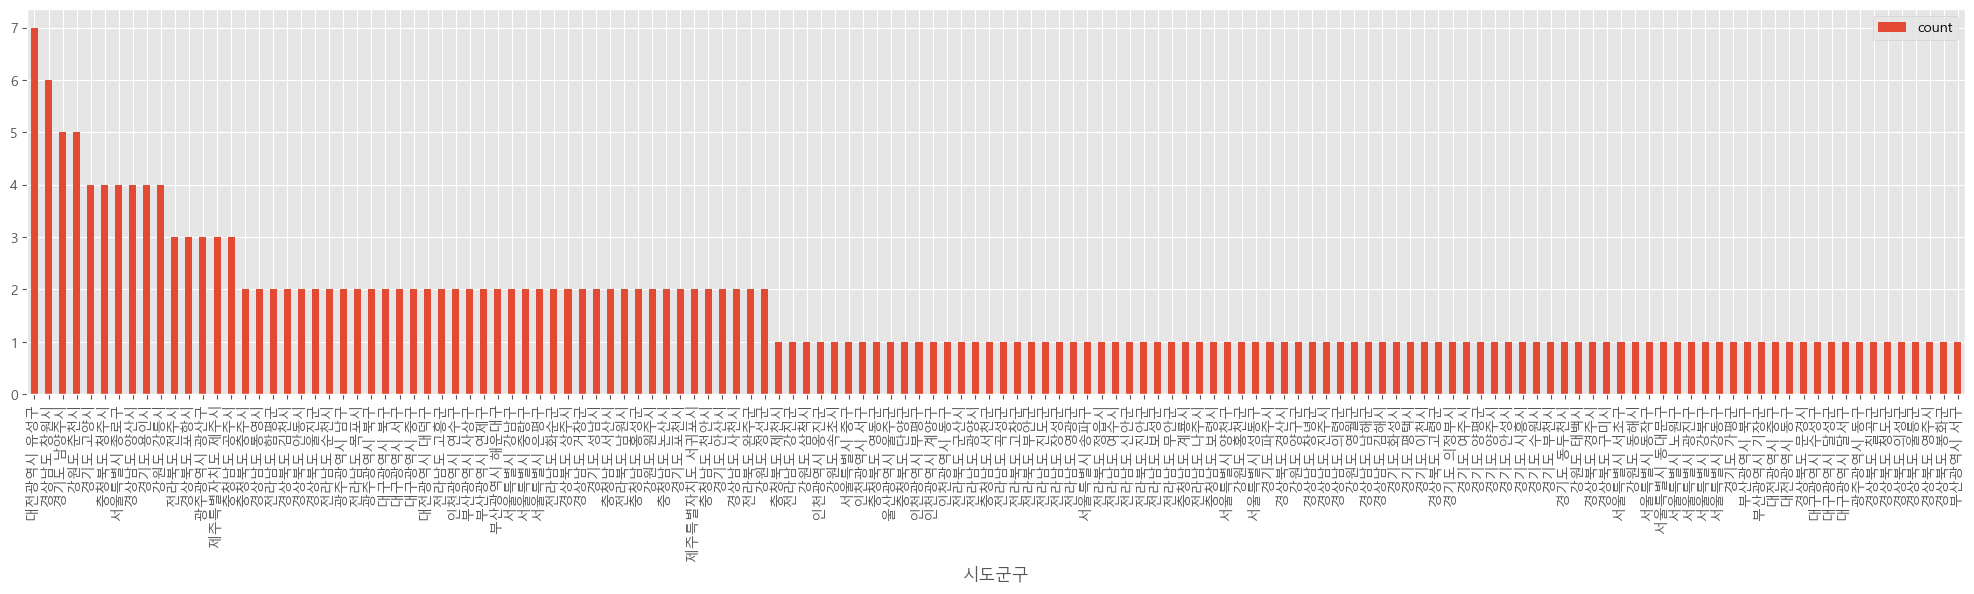

In [ ]:
MC_ratio = local_MC_Population[['count']] #인덱스, count만 추출
MC_ratio = MC_ratio.sort_values('count', ascending = False)
plt.rcParams["figure.figsize"] = (25, 5)
MC_ratio.plot(kind = 'bar', rot = 90) # *90도로 돌려주어서 글자가 안겹치게 함. 
plt.show()

# local_MC_Population 객체의 [‘count’] 컬럼 값을 오름차순으로 정렬하여, 
# 행정 구역별 공공보건의료기관 수에 대한 바 차트를 그림

### [행정구역별로 인구수 대비 공공보건의료기관 비율에 대한 바 차트 그리기]

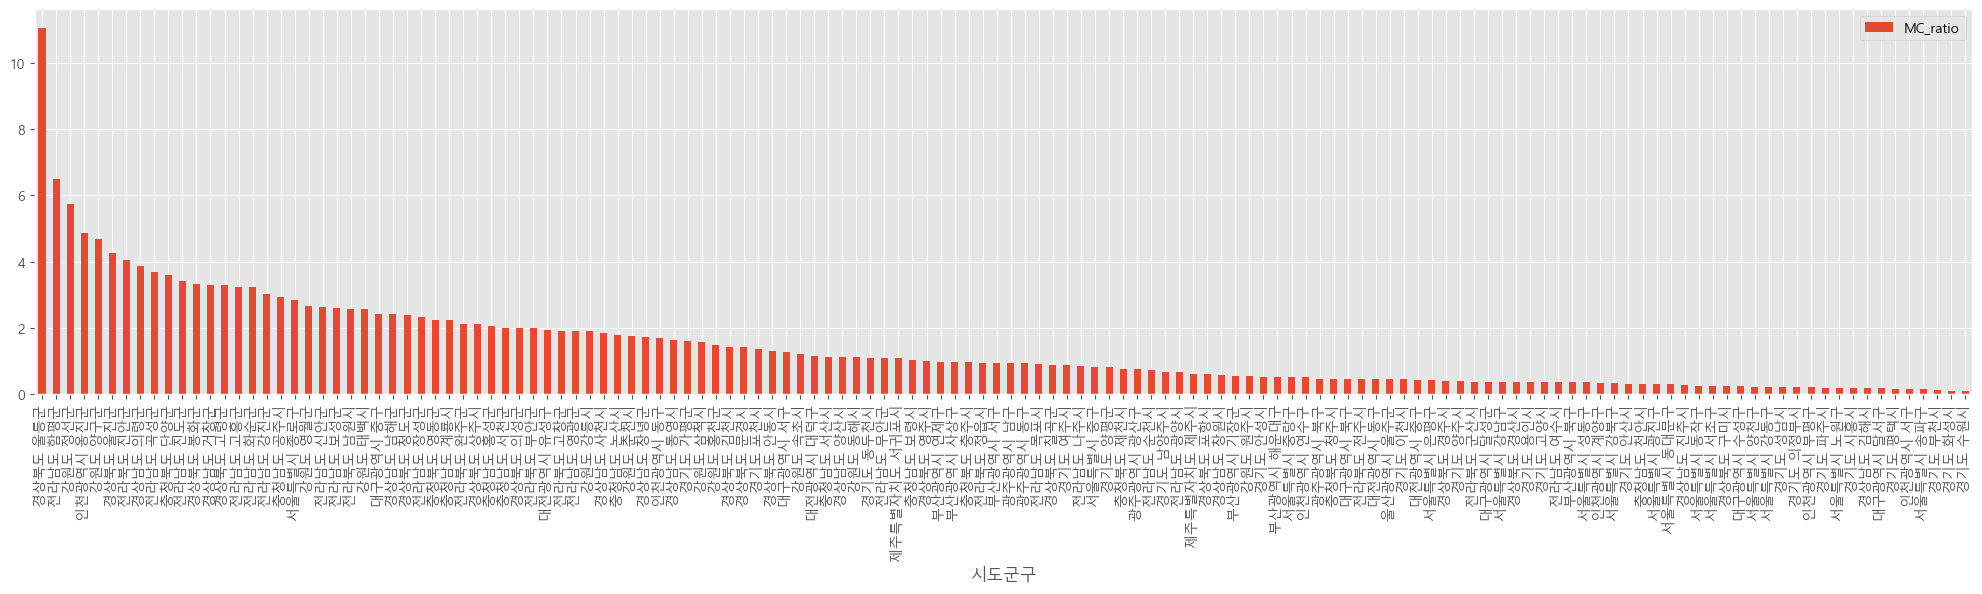

In [32]:
MC_ratio = local_MC_Population[['MC_ratio']]
MC_ratio = MC_ratio.sort_values('MC_ratio', ascending = False)
plt.rcParams["figure.figsize"] = (25, 5)
MC_ratio.plot(kind = 'bar', rot = 90)
plt.show()

# local_MC_Population 객체의 [‘MC_ratio’] 컬럼 값을 오름차순으로 정렬하여, 
# 행정구역별로 인구수 대비 공공보건의료기관 비율에 대한 바 차트를 그림

## 블록맵으로 시각화하기
### [데이터 준비하기]

In [34]:
import os
data_draw_korea = pd.read_csv('./data/data_draw_korea.csv',index_col = 0, encoding = 'UTF-8', engine = 'python')
data_draw_korea.head() 

,인구수,shortName,x,y,면적,광역시도,행정구역
0,202520,강릉,11,4,1040.07,강원도,강릉시
1,25589,고성(강원),9,0,664.19,강원도,고성군
2,86747,동해,11,5,180.01,강원도,동해시
3,63986,삼척,11,8,1185.80,강원도,삼척시
4,76733,속초,9,1,105.25,강원도,속초시


### [행정구역 이름 매핑하기]

In [35]:
data_draw_korea['시도군구'] = data_draw_korea.apply(lambda r: r['광역시도'] + ' ' + r['행정구역'], axis = 1)
# [‘광역시도’]와 [‘행정구역’] 컬럼 값을 연결하여 새로운 [‘시도군구’] 컬럼으로 추가

data_draw_korea = data_draw_korea.set_index("시도군구")
# [‘시도군구’] 컬럼을 데이터프레임 병합에 사용할 인덱스로 설정

data_draw_korea.head() 

,인구수,shortName,x,y,면적,광역시도,행정구역
시도군구,,,,,,,
강원도 강릉시,202520,강릉,11,4,1040.07,강원도,강릉시
강원도 고성군,25589,고성(강원),9,0,664.19,강원도,고성군
강원도 동해시,86747,동해,11,5,180.01,강원도,동해시
강원도 삼척시,63986,삼척,11,8,1185.80,강원도,삼척시
강원도 속초시,76733,속초,9,1,105.25,강원도,속초시


In [36]:
data_draw_korea_MC_Population_all = pd.merge(data_draw_korea,local_MC_Population, 
				how = 'outer',left_index = True, right_index = True)
# data_draw_korea와 local_MC_Population을 outer join 병합

data_draw_korea_MC_Population_all.head()
# 이렇게 3개의 엑셀이 다 합쳐짐 > 근데 중복도 많고 더럽게 합쳐진 상태임.

,인구수_x,shortName,x,y,면적,광역시도,행정구역,시도,군구,count,인구수_y,MC_ratio
시도군구,,,,,,,,,,,,
강원도 강릉시,202520,강릉,11,4,1040.07,강원도,강릉시,강원도,강릉시,4.0,210678.0,1.898632
강원도 고성군,25589,고성(강원),9,0,664.19,강원도,고성군,NaN,NaN,NaN,NaN,NaN
강원도 동해시,86747,동해,11,5,180.01,강원도,동해시,강원도,동해시,1.0,89186.0,1.121252
강원도 삼척시,63986,삼척,11,8,1185.80,강원도,삼척시,강원도,삼척시,1.0,63487.0,1.575126
강원도 속초시,76733,속초,9,1,105.25,강원도,속초시,강원도,속초시,1.0,82541.0,1.211519


### [블록맵으로 시각화하기]

In [37]:
BORDER_LINES = [
    [(3, 2), (5, 2), (5, 3), (9, 3), (9, 1)], # 인천
    [(2, 5), (3, 5), (3, 4), (8, 4), (8, 7), (7, 7), (7, 9), (4, 9), (4, 7), (1, 7)], # 서울
    [(1, 6), (1, 9), (3, 9), (3, 10), (8, 10), (8, 9),
     (9, 9), (9, 8), (10, 8), (10, 5), (9, 5), (9, 3)], # 경기도
    [(9, 12), (9, 10), (8, 10)], # 강원도
    [(10, 5), (11, 5), (11, 4), (12, 4), (12, 5), (13, 5),
     (13, 4), (14, 4), (14, 2)], # 충청남도
    [(11, 5), (12, 5), (12, 6), (15, 6), (15, 7), (13, 7),
     (13, 8), (11, 8), (11, 9), (10, 9), (10, 8)], # 충청북도
    [(14, 4), (15, 4), (15, 6)], # 대전시
    [(14, 7), (14, 9), (13, 9), (13, 11), (13, 13)], # 경상북도
    [(14, 8), (16, 8), (16, 10), (15, 10),
     (15, 11), (14, 11), (14, 12), (13, 12)], # 대구시
    [(15, 11), (16, 11), (16, 13)], # 울산시
    [(17, 1), (17, 3), (18, 3), (18, 6), (15, 6)], # 전라북도
    [(19, 2), (19, 4), (21, 4), (21, 3), (22, 3), (22, 2), (19, 2)], # 광주시
    [(18, 5), (20, 5), (20, 6)], # 전라남도
    [(16, 9), (18, 9), (18, 8), (19, 8), (19, 9), (20, 9), (20, 10)], # 부산시
]

# 블록맵의 행정구역 경계선을 그리기 위해 행정구역의 블록 위치인 x, y 데이터를 정의
# 노가다. 하드코딩임.
# 인천의 아웃라인, 서울의 아웃라인 등을 그어주는 과정
# 참고로 (y,x) 기준이다.

In [ ]:
def draw_blockMap(blockedMap, targetData, title, color ):
    whitelabelmin = (max(blockedMap[targetData]) - min(blockedMap[targetData])) * 0.25 + min(blockedMap[targetData])
    # (최대-최소)*25%+최소 = 하위 25%

    datalabel = targetData  # 오른쪽 컬러 게이지 표시 

    vmin = min(blockedMap[targetData])
    vmax = max(blockedMap[targetData])
    # 히트맵 생성을 위한 pcolor 파라미터 입력용 데이터 
    # 가장 진한색과 약한색 정해줌

    mapdata = blockedMap.pivot(index='y', columns='x', values=targetData)
    # 데이터 열 중에서 두 개의 열을 각각 행 인덱스, 열 인덱스로 사용하여 데이터를 조회하여 펼쳐놓은 것
    # 이 코드에서 핵심은 pivot이다. 
    # pivot은 y와 x값을 2차원 적인 전체 행렬(13바이11)에 다가 (x,y)에 해당하는 부위에 값을 넣음.
    # pivot말고 나머지는 다 꾸미는 과정임. 생략해도 좀 못생겨지기만 할 뿐
    # pivot없으면 지도가 거꾸로 나옴.(제주도가 위쪽)
    masked_mapdata = np.ma.masked_where(np.isnan(mapdata), mapdata)
    # 히트맵에서 제외되는 부분. 
    # ma.masked_where(조건,x):조건이 True인 경우 x를 마스킹한 배열로 반환
    
    plt.figure(figsize=(8, 13))
    plt.title(title)
    plt.pcolor(masked_mapdata, vmin=vmin, vmax=vmax, cmap=color, edgecolor='#aaaaaa', linewidth=0.5)
    # : Vmin : 최소값, vmax=최대값, cmap: 컬러맵, edgecolor : 테두리 컬러, linewidth=테두리 두께
    plt.gca().invert_yaxis()
    # y축 뒤집기 (위쪽이 제주도가 되는 문제 해결)

    # 지역 이름 표시
    for idx, row in blockedMap.iterrows():
        annocolor = 'white' if row[targetData] > whitelabelmin else 'black'
    # 하위 25%보다 큰 데이터는 검은색으로 글자를 쓴다. 0에서 4까지 진하기 조절해서 색깔 넣어줌. (생략가능)
    
        # 광역시는 구 이름이 겹치는 경우가 많아서 시단위 이름도 같이 표시한다. (중구, 서구)
        if row['광역시도'].endswith('시') and not row['광역시도'].startswith('세종'):
            dispname = '{}\n{}'.format(row['광역시도'][:2], row['행정구역'][:-1])
            # 정규화과정. 문자열 format 양식 (ex)인천광역시 연수구-> 인천/연수

            if len(row['행정구역']) <= 2:
                dispname += row['행정구역'][-1]
        else:
            dispname = row['행정구역'][:-1]
        # 정규화과정. 문자열이 너무 짧아진 경우 다시 끝을 붙여줌 
        # (Ex) 울산 남 -> 울산 남구

         # 텍스트 추가 (블록 중앙에 위치)
        plt.text(row['x'] + 0.5, row['y'] + 0.5, dispname, fontsize=8, weight='bold',
                 color=annocolor, ha='center', va='center')
        
    plt.xticks([])
    plt.yticks([])
    plt.show()

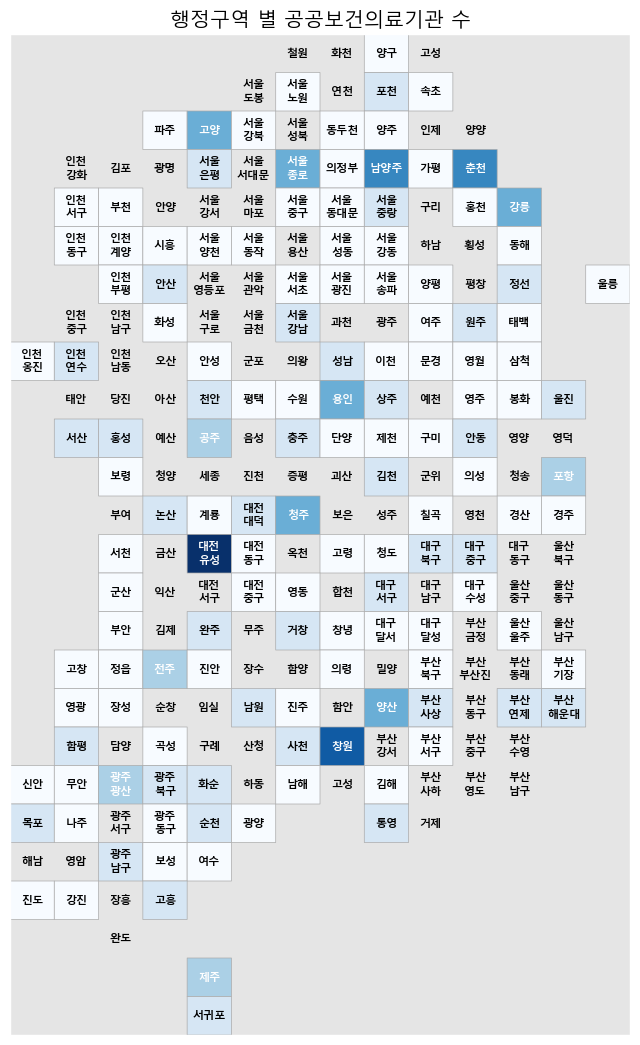

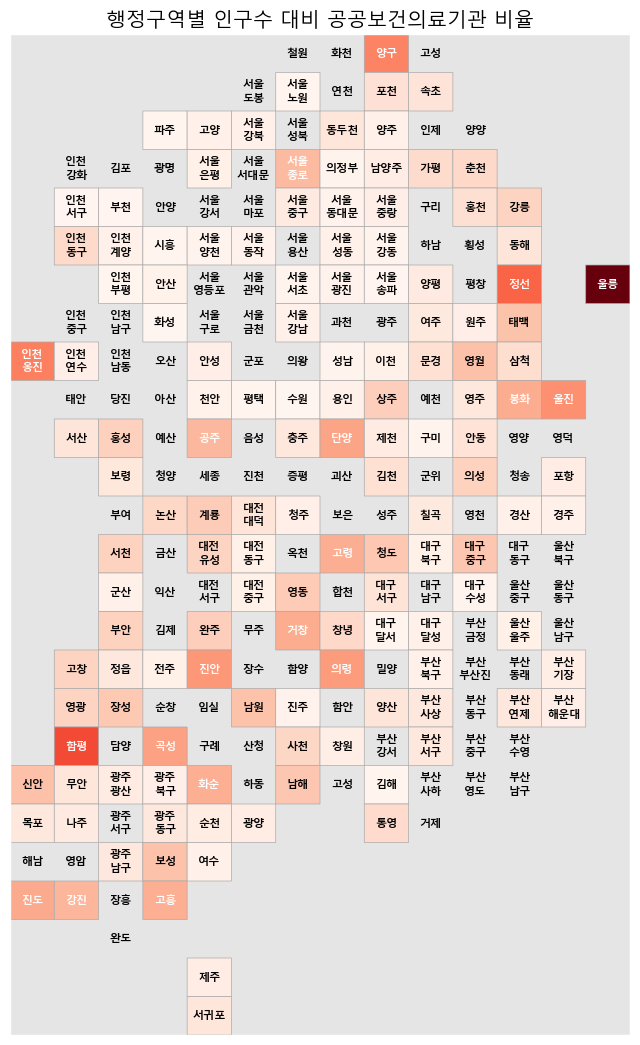

In [43]:
draw_blockMap(data_draw_korea_MC_Population_all, 'count', '행정구역 별 공공보건의료기관 수', 'Blues')
# <행정구역별 공공보건의료기관 수를 블록맵으로 시각화 = 파랑(개수)>
# data_draw_korea_MC_Population_all 객체의 [‘count’] 컬럼 값에 대해 Blues 색상 스펙트럼을 사용하여 블록맵 작성

draw_blockMap(data_draw_korea_MC_Population_all, 'MC_ratio', '행정구역별 인구수 대비 공공보건의료기관 비율', 'Reds')
# <인구수 대비 공공보건의료기관 비율을 블록맵으로 시각화 = 빨강(비율)>
# data_draw_korea_MC_Population_all 객체의 [‘MC_ratio’] 컬럼 값에 대해 Reds 색상 스펙트럼을 사용하여 블록맵 작성
